In [1]:
import somoclu
from astropy.table import Table, join
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tqdm.auto import tqdm

Alexandria's based `TrainSOM` 75x150 = 174.02s for 200k sources

In [2]:
cat = Table.read('/home/aalvarez/Work/Data/PV/Calib/BuildReferenceSamplePhotometry/reference_sample_phot.fits')
cat.rename_column('ID', 'OBJECT_ID')

In [3]:
mer = Table.read('/home/aalvarez/Work/Data/PV/Calib/MerNormalizer/output_catalog.fits')

In [4]:
# Adapted from config
colors = {
    'U-G': ('lsst/u', 'lsst/g'),
    'G-R': ('lsst/g', 'lsst/r'),
    'R-I': ('lsst/r', 'lsst/i'),
    'I-Vis': ('lsst/i', 'euclid/VIS'),
    'Vis-Z': ('euclid/VIS', 'lsst/z'),
    'Z-Y': ('lsst/z', 'euclid/Y'),
    'Y-J': ('euclid/Y', 'euclid/J'),
    'J-H': ('euclid/J', 'euclid/H')
}

In [5]:
for (a, b) in colors.values():
    maska = cat[a] <= 0
    maskb = cat[b] <= 0
    cat[a][maska] = 1e-07
    cat[b][maskb] = 1e-07

In [6]:
cross = join(cat, mer[['OBJECT_ID', 'Ztrue']], 'OBJECT_ID', 'left')

In [7]:
data = np.zeros((len(cat), len(colors)), dtype=np.float32)

In [8]:
for i, (a, b) in enumerate(colors.values()):
    print(a, b)
    data[:, i] = np.log10(cross[a] / cross[b])
assert np.isfinite(data).all()

lsst/u lsst/g
lsst/g lsst/r
lsst/r lsst/i
lsst/i euclid/VIS
euclid/VIS lsst/z
lsst/z euclid/Y
euclid/Y euclid/J
euclid/J euclid/H


In [34]:
som = somoclu.Somoclu(75, 150, initialization='random')
%time som.train(data, epochs=2)

CPU times: user 5min 15s, sys: 685 ms, total: 5min 15s
Wall time: 44.2 s


In [35]:
compatible = np.moveaxis(som.codebook, -1, 0)

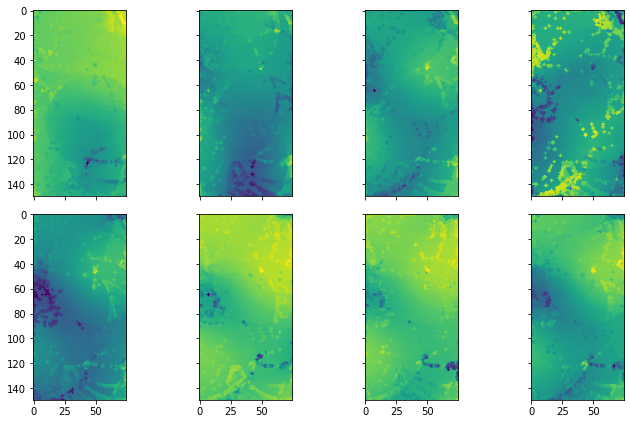

In [36]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=True, sharey=True, figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(compatible[i])
fig.tight_layout()

In [37]:
fits.PrimaryHDU(compatible, header=fits.Header({'DISTFUNC': 'N6Euclid3SOM8Distance2L2E'})).writeto('/home/aalvarez/Work/Data/PV/Calib/SOMOCLU.fits', overwrite=True)